In [1]:
from typing import NamedTuple
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import numpy as np

from tools.iou_utils import get_max_iou

from cv2 import rectangle
from mmcv import Config
from mmcv.runner import wrap_fp16_model, load_checkpoint
from mmdet.models import build_detector
from mmcv.parallel import MMDataParallel
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

# PSTR's person search

This notebook uses PSTR model to illustrate the person search step-by-step.



## Load data, model and compute features.

Those are the line of codes needed to run PSTR on some hand-picked samples for illustration.

s9 s10 puis des autres

In [23]:
# Load configs file with boiler plate
cfg = Config.fromfile(Path("./configs/pstr/pstr_r50_24e_cuhk.py"))
cfg.model.pretrained = None
cfg.data.test.test_mode = True
cfg.model.train_cfg = None

In [24]:
# Get pedes_dataset
pedes_dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    [ pedes_dataset[i] for i in range(100+1)],
    samples_per_gpu=1,
    workers_per_gpu=1,
    dist=False,
    shuffle=False)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [25]:
# Get model and weights with boilerplate
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')).eval()
load_checkpoint(
    model, 
    str(Path.home() / "models" / "pstr_resnet_cuhk" / "pstr_r50_cuhk.pth"), 
    map_location='cpu'
)
# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
model.CLASSES = pedes_dataset.CLASSES
model = MMDataParallel(model, device_ids=[0])

/opt/conda/lib/python3.8/site-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `feedforward_channels` in BaseTransformerLayer has been deprecated, now you should set `feedforward_channels` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `ffn_dropout` in BaseTransformerLayer has been deprecated, now you should set `ffn_drop` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `ffn_num_fcs` in BaseTransformerLayer has been deprecated, now you should set `num_fcs` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mmcv/cnn/bricks/transformer.py:92: UserWarning: The arguments `dropout` in MultiheadAttention has been deprecated, now you can separat

3
load checkpoint from local path: /home/reusm/models/pstr_resnet_cuhk/pstr_r50_cuhk.pth


In [26]:
frame_paths = [
    data['img_metas'][0].data[0][0]['filename']
    for data in data_loader
]

In [27]:
with torch.no_grad():
    results = [
        model(return_loss=False, rescale=True, **data)
        for data in data_loader
    ]

In [7]:
# Helper data structure
class ModelOutput(NamedTuple):
    # 2D | (100, 4)
    bboxes: np.ndarray
    # 1D | (100)
    scores: np.ndarray
    # 2D | (100, 256*3)
    features: np.ndarray

def from_result_to_model_output(result: np.ndarray) -> ModelOutput:
    return ModelOutput(
        bboxes=result[:, :4].astype(np.int32),
        scores=result[:, 4],
        features= result[:, 5:],
    )

In [8]:
model_outputs = [
    from_result_to_model_output(result[0][0])
    for result in results
]

In [9]:
all_bboxes = [ output.bboxes for output in model_outputs[:10]]
widths = np.array([
    [
        bbox[2] - bbox[0]
        for bbox in bboxes
    ]
    for bboxes in all_bboxes
])
heights = np.array([
    [
        bbox[3] - bbox[1]
        for bbox in bboxes
    ]
    for bboxes in all_bboxes
])
print(
    f"{'Width stats':-^50s}\n"
    f"{int(widths.mean()) = :_d}, "
    f"{int(widths.std()) = :_d}\n"
    f"{'Height stats':-^50s}\n"
    f"{int(heights.mean()) = :_d}, "
    f"{int(heights.std()) = :_d}\n"
)

-------------------Width stats--------------------
int(widths.mean()) = 59, int(widths.std()) = 29
-------------------Height stats-------------------
int(heights.mean()) = 172, int(heights.std()) = 80



In [18]:
all_bboxes[0][:10]

array([[422, 120, 512, 387],
       [356, 101, 388, 185],
       [473, 152, 531, 376],
       [357,  97, 387, 177],
       [459, 120, 525, 368],
       [405, 167, 469, 363],
       [348,  98, 380, 192],
       [ 28, 184,  82, 355],
       [419, 120, 496, 357],
       [ 51, 184,  90, 306]], dtype=int32)

## PSTR query processing

We show how PSTR compute detections and features on **frame query**.

We filter detections with low confidence score and we retrieve the correct bbox using the IoU.

In [9]:
# Load query image
query_path = frame_paths[0]
query_image = plt.imread(frame_paths[0])

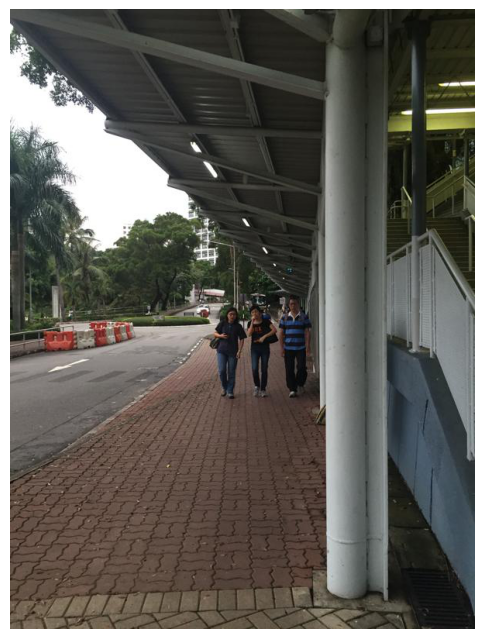

In [10]:
# Show query_image
plt.figure(figsize=(6, 10))
plt.imshow(query_image)
plt.axis('off')
plt.show()


In [11]:
# Get query bbox and draw them on the picture
query_output = model_outputs[0]
query_bboxes = query_output.bboxes

query_image_bboxes = query_image.copy()
for bbox in query_bboxes:
    query_image_bboxes = rectangle(query_image_bboxes, bbox[:2], bbox[2:], color=0)

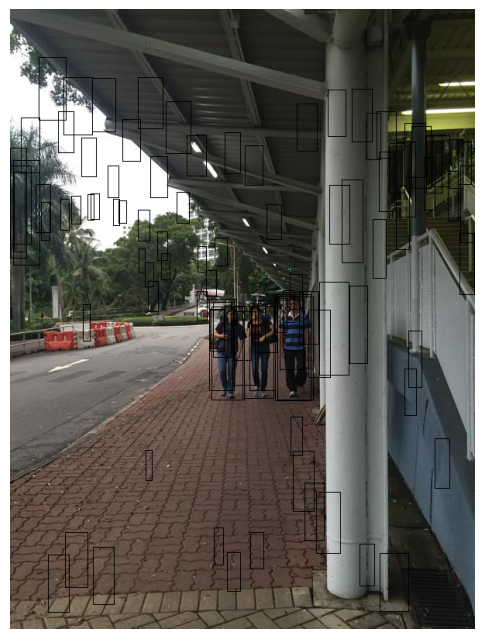

In [12]:
# Show query_image with bboxes
plt.figure(figsize=(6, 10))
plt.imshow(query_image_bboxes)
plt.axis('off')
plt.show()


In [13]:
# Filter output by confidence thresholding
threshold = .7
ok_indices_query = query_output.scores >= threshold
filtered_query_output = ModelOutput(
    bboxes=query_output.bboxes[ok_indices_query],
    scores=query_output.scores[ok_indices_query],
    features=query_output.features[ok_indices_query],
)

In [14]:
# Get filtered bboxes and draw rectangles
filtered_query_image_bboxes = query_image.copy()
for bbox in filtered_query_output.bboxes:
    filtered_query_image_bboxes = rectangle(filtered_query_image_bboxes, bbox[:2], bbox[2:], color=0)

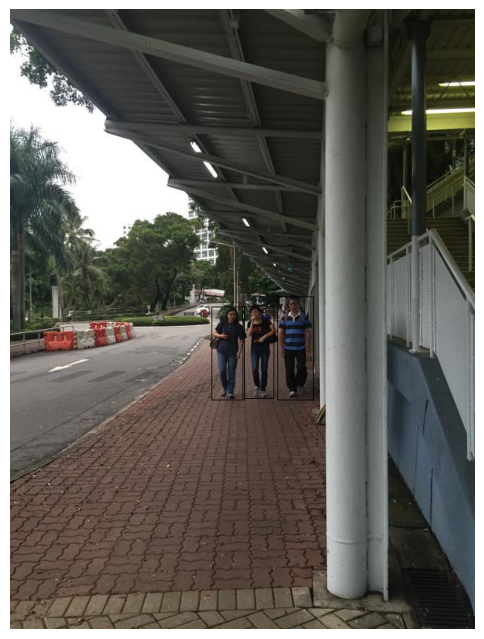

In [15]:
# Show query_image with bboxes
plt.figure(figsize=(6, 10))
plt.imshow(filtered_query_image_bboxes)
plt.axis('off')
plt.show()

In [16]:
# Select bbox with best iou
_, _, n_best = get_max_iou(
    filtered_query_output.bboxes, [303, 381, 335, 500])
correct_filtered_query_output_bbox = filtered_query_output.bboxes[n_best]

In [17]:
# Draw rectangle
correct_query_image_bbox = rectangle(query_image, correct_filtered_query_output_bbox[:2], correct_filtered_query_output_bbox[2:], color=0)

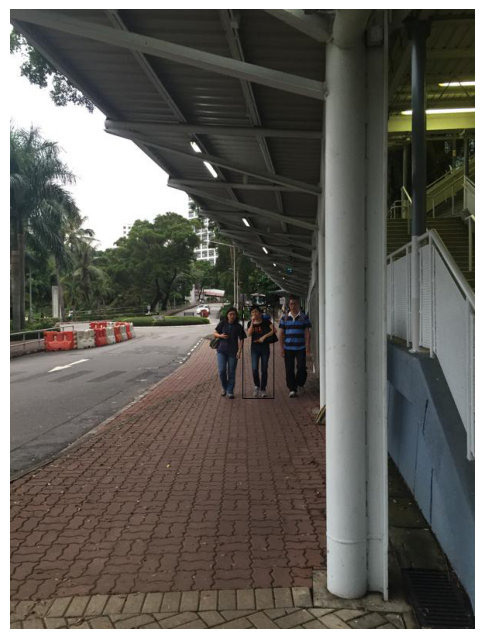

In [18]:
# Show query_image with bboxes
plt.figure(figsize=(6, 10))
plt.imshow(correct_query_image_bbox)
plt.axis('off')
plt.show()

In [19]:
# Get features
query_features = filtered_query_output.features[n_best]

## PSTR performs search in the gallery

1. We filter detection with good confidence score
2. We compute the similarity between the query features and the filtered similarities
3. We keep the best similarity in each frame
4. We rank the frame by similarity score

In [20]:
# Set gallery outputs
gallery_outputs = model_outputs[1:]

In [21]:
# Filter detection by threshold
ok_indices_galleries = [
    gallery_outputs.scores >= threshold
    for gallery_outputs in gallery_outputs
]
filtered_galleries_bboxes = [
    gallery_outputs.bboxes[ok_inds]
    for gallery_outputs, ok_inds in zip(gallery_outputs, ok_indices_galleries)
]
filtered_galleries_features = [
    gallery_outputs.features[ok_inds]
    for gallery_outputs, ok_inds in zip(gallery_outputs, ok_indices_galleries)
]

In [22]:
# Compute similarities
similarities_for_all = [
    query_features @ gallery_features.T
    for gallery_features in filtered_galleries_features
]

In [23]:
# We keep best similarities for each gallery image
best_similarities = np.array([
    similarities.max()
    if similarities.size > 0
    else 0
    for similarities in similarities_for_all
])

In [24]:
# Determine the ranking of each gallery image based on bidule
rank_indices_by_similarity = best_similarities.argsort()[::-1]

/tmp/ipykernel_96971/199820001.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


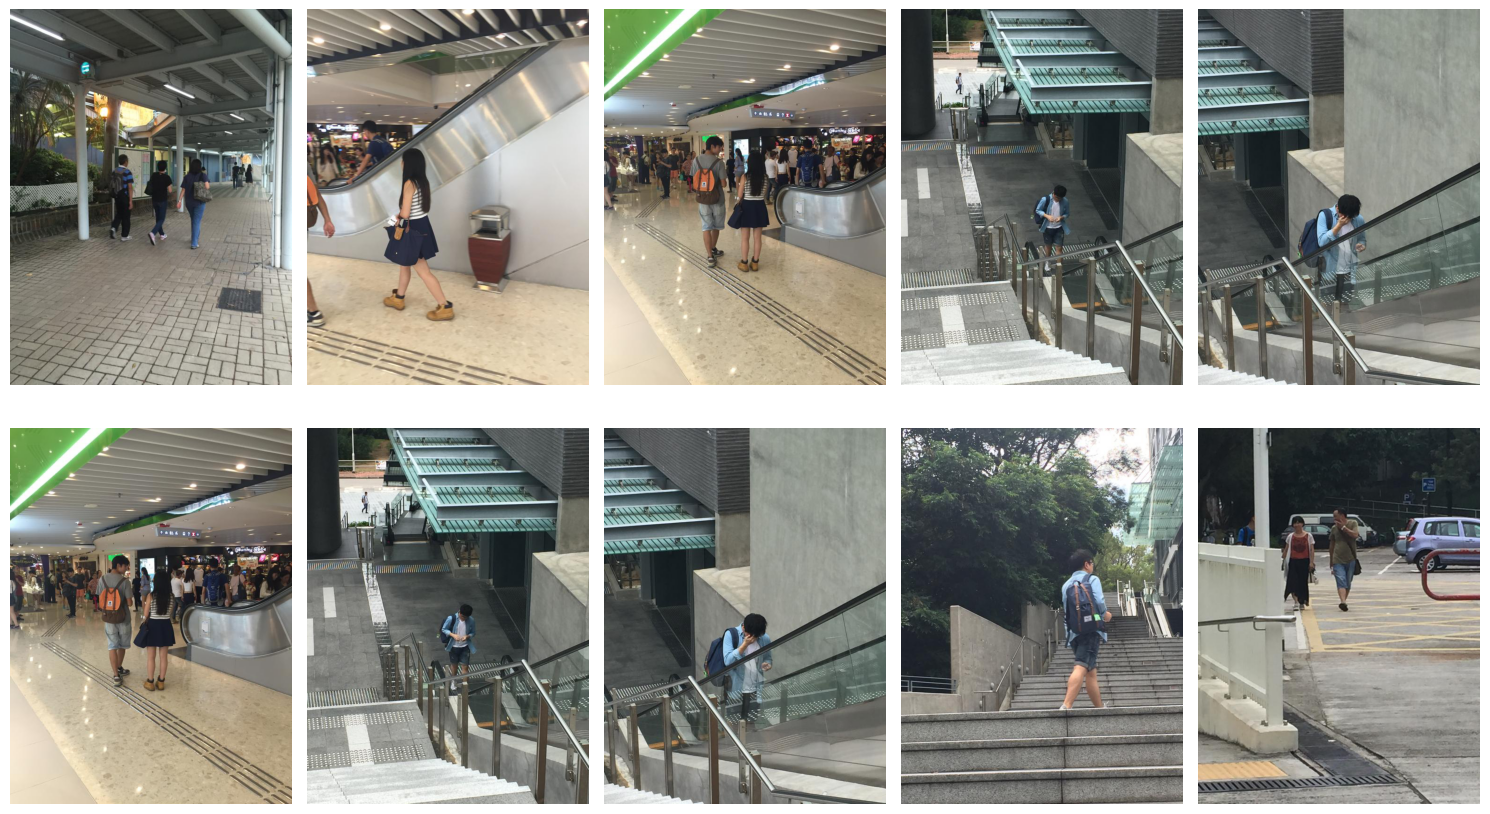

In [25]:
# Display top 10 frames
f, axs = plt.subplots(2, 5, figsize=(15, 9))
for i in range(2):
    for j in range(5):
        ind = i*2 + j
        frame = plt.imread(frame_paths[1+ind])
        axs[i, j].imshow(frame)
        axs[i, j].axis("off")
plt.axis('off')
f.tight_layout()
f.show()

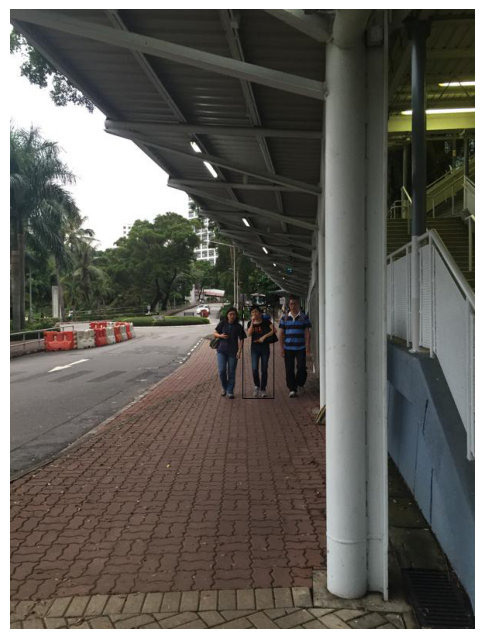

In [26]:
# Show query_image
plt.figure(figsize=(6, 10))
plt.imshow(query_image)
plt.axis('off')
plt.show()
